In [12]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import datetime
import tensorflow as tf
import os
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img


## Save the images from the entry camera into a database

In [2]:
#Assumptions made at this stage: 
#Each unique visitor's shoes will only be captured once by the entrance camera
# image database (contains images taken by the entry camera)
db = []

folder_dir = 'base_photos'    
images = Path(folder_dir).glob('*.jpg')
gen = ImageDataGenerator(rotation_range=60, horizontal_flip = True) #change accordingly
count = 1 #number of visitors

for image in images:
    tmp = str(image)[len(folder_dir)+1:][:-4].split("_")
    tmp_date = tmp[0]
    tmp_time = tmp[1]
    date = tmp_date.split(".")
    time = tmp_time.split(".")
    img = cv.imread(str(image))
    date_time = datetime.datetime(int(date[0]), int(date[1]), int(date[2]), int(time[0]), int(time[1]), int(time[2]))
    num = 1
    db.append({'image':img, 'id':count, 'number':num, 'datetime': date_time})
    #image augmentation
    original_image = np.expand_dims(img,0) #expand dimensions for compatibility
    aug_iter = gen.flow(original_image, batch_size = 10) #to generate 10 augmented images from original image
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
    for i in aug_images:
        num+=1
        db.append({'image':i, 'id':count,'number':num, 'datetime': date_time})
    count += 1 #increment count for next shoe
# to display the 6th picture in the photos directory
# cv.imshow('test', db[5]['image'])
# cv.waitKey(0)

The names of the images in `base_photos` is saved in the format `2022.10.18_10.38.27_esp32-cam.jpg` which can be interpreted as the photo was taken on 18th October 2022, 10:38:27. 
Since we have made the assumption that each visitor's shoes will only be captured once, all original images of the shoes (non-augmented images) will have `number` = 1.

Subsequently, the image is augmented and added to the database with varying `number` values from 2 to 11.

## Testing the Template Matching method

We want to find the ids of shoes in folder `to_retrieve_ids`. Note that in the folder, only `1.jpg` is exactly the same as picture `4-1.jpg` in `base_photos`. Other pictures in `to_retrieve_ids` are not exact replicate of pictures in `base_photos`.

In [3]:
folder_dir = 'to_retrieve_ids'
images = Path(folder_dir).glob('*.jpg')

actual_ids = [4, 4, 2, 3]
identified = []    # stores result from template matching

for image in images:
    template = cv.imread(str(image), cv.IMREAD_COLOR)
    threshold = 0.70   # set threshold; high (ie. 1) means "more strict"
    tmp = []    # stores detected ids for this shoe; if empty means no id is assigned to this shoe
    
    # perform match operation
    for item in db:
        res = cv.matchTemplate(item['image'], template, cv.TM_CCOEFF_NORMED)
        loc = np.where(res >= threshold)
        if (len(loc[0])!=0 and len(loc[1])!=0):    # if there's a match
            tmp.append(item['id'])
            
    identified.append(tmp)
    
identified

[[1, 2, 2, 2, 3, 3, 4], [1, 1, 2, 2, 3, 3, 4, 4, 4], [1, 2, 2, 4], []]

Here's an interpretation of the variable `identified`:

For this threshold, `1.jpg` in `to_retrieve_ids` is correctly assigned to id 4, but is mistaken to be id 2 as well. Same for `2.jpg` which is mistaken to be id 1 and id 2. The last element of `identified` is an empty list, which means that the algorithm failed to identify that `4.jpg` is actually id 3.

Note: after changing the threshold to 0.85, ids are correctly assigned to `1.jpg` and `2.jpg`. But the algorithm failed to recognise that `3.jpg` is actually id 2 and `4.jpg` is id 3.

We shall see if it will improve with image augmentation + background removal

In [4]:
# to visualize bounding boxes
a = cv.imread('base_photos/2022.10.18_10.40.07_esp32-cam.jpg')     # can change
b = cv.imread('to_retrieve_ids/2022.10.18_10.50.03_esp32-cam.jpg', cv.IMREAD_COLOR)    # can change


res = cv.matchTemplate(a, b, cv.TM_CCOEFF_NORMED)
w, h = b.shape[1], b.shape[0]
threshold = 0.7
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(a, pt, (pt[0] + w, pt[1] + h), (0, 255, 255), 2)
#cv.imshow('Detected', a)
#cv.waitKey(0)

## Background Removal method

In order to implement the template matching method to succesfully identify the same shoe across different images, it is important for us to extract the image of the shoe without the background to be used as the template for matching. We will assume that there will be no changes in the background across time and thus, a fixed background image will be used to remove the background from the other images. 

The code below utilises the same codes from earlier with the only difference being the addition of the background subtraction process through the `cv.subtract` method in order to test the usefulness of the addition of background subtraction to our algorithm. The resulting images is added to an `updated_db` database.

(The `plt.imshow` method is utilised below to retrieve and display the images of the removed background in-line with the notebook as the `cv.imshow` method crashes my Macbook on VS Code... Also, the camera shifted while taking the photos so I will need to retake them again. )

In [15]:
bg_img = cv.imread('to_update_images/Cam1/background.jpg') #Set background image
folder_dir = 'to_update_images/Cam1/uploads' #Set folder directory to receive pictures
upload_dir = 'to_update_images/Cam1/bg_removed' #Set folder to save background removed pictures
if not os.path.exists(upload_dir):
    os.makedirs(upload_dir)
parent_directory = os.getcwd()
images = Path(folder_dir).glob('*.jpg')
for image in images:
    name = str(image)[len(folder_dir)+1:]
    img = cv.imread(str(image))
    img_nobg = cv.subtract(img, bg_img)
    tmp = array_to_img(img_nobg)
    tmp.save(f"{upload_dir}/{name}.jpg")

Ignore the part below for now

In [15]:
updated_db = []

bg_img = cv.imread('to_update_images/Cam1/background.jpeg')
folder_dir = 'to_update_images/Cam1/Uploads'
images = Path(folder_dir).glob('*.jpeg')
gen = ImageDataGenerator(rotation_range=60, horizontal_flip = True)
count = 1

for image in images:
    tmp = str(image)[-19:-6] 
    img = cv.imread(str(image))
    date_time = datetime.datetime(int(tmp[0:4]), int(tmp[4:6]), int(tmp[6:8]), int(tmp[8:10]), int(tmp[10:12]), int(tmp[12:14]))
    num = 1
    updated_db.append({'image':img, 'id':count, 'number':num, 'datetime': date_time})
    img_nobg = cv.subtract(img, bg_img)
    original_image = np.expand_dims(img_nobg,0)
    aug_iter = gen.flow(original_image, batch_size = 10)
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
    for i in aug_images:
        num+=1
        updated_db.append({'image':i, 'id':count,'number':num, 'datetime': date_time})
    count += 1


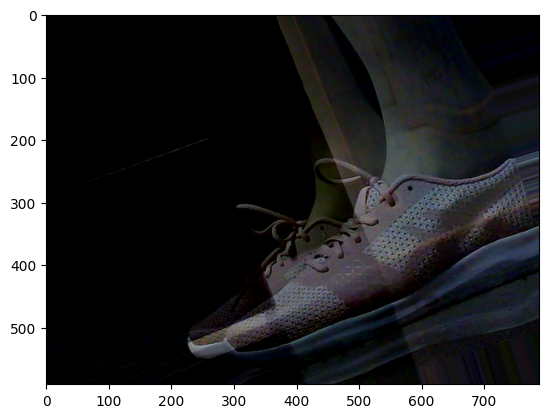

In [16]:
# to check if 
plt.imshow(cv.cvtColor(updated_db[79]['image'], cv.COLOR_BGR2RGB))